In [1]:
import os
import numpy as np
import math
from random import sample

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

### Task_1

1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Без графиков домашку не принимаю

In [2]:
device = torch.device('cpu')

##### Описание решения:

* Генерирую в заданном диапазоне значения X, генерирую для каждого значения соответствующее значение Y.
* Сэмплю по 25 точек, один такой сэмпл - один True обект, подаваемый дискриминатору.
* Запускаю обучение генератора и дискриминатора.

In [3]:
x = np.linspace(-25, 25, 10000)
y = np.sin(x)/x - x/10

x_y = list(zip(x, y))

Вид непрерывной (True) функции на участке от -25 до +25.

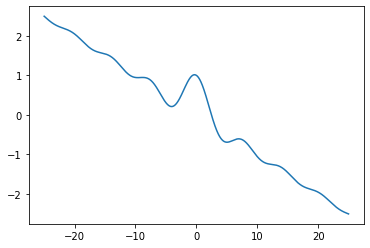

In [4]:
plt.plot(x,y)

Примеры объектов из True датасета.

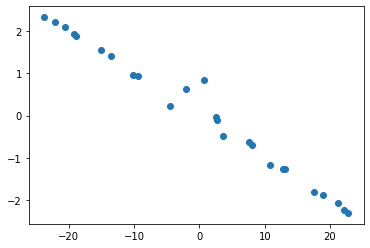

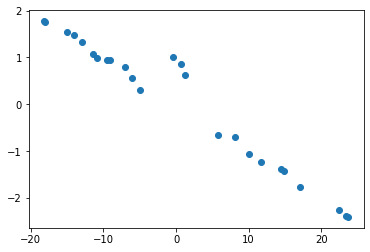

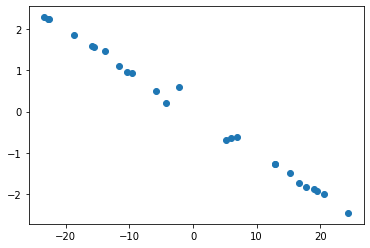

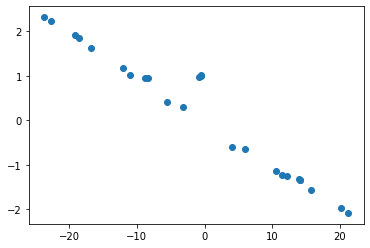

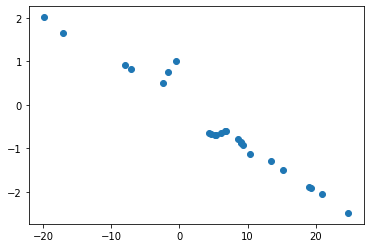

In [5]:
for i in range(5):
    dots = sample(x_y, 25)

    x_ = [val[0] for val in dots]
    y_ = [val[1] for val in dots]

    plt.scatter(x_, y_)
    plt.show()


##### Объявление моделей:

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def layers_block(in_size,
                         out_size,
                         normalize=True):
            layers = [nn.Linear(in_size, out_size)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_size, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *layers_block(latent_dim, 128, normalize=False),
            *layers_block(128, 256),
            *layers_block(256, 512),
            *layers_block(512, 1024),
            nn.Linear(1024, int(np.prod(obj_shape))),
#             nn.Tanh()
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, z):
        obj = self.model(z)
        obj = obj.view(obj.size(0), *obj_shape)
        return obj


In [7]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(obj_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

##### Создание дата-сета:

In [9]:
class FunctionDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        
        x = np.linspace(-10, 10, 10000)
        y = np.sin(x)/x - x/10
        
        x_y = list(zip(x, y))
        self.data = [torch.tensor(sample(x_y, 5)) for i in range(100000)]


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = self.data[idx]                        
        
        if self.transform != None:
            item = self.transform(item)

        return item 

In [10]:
real_data = FunctionDataset()

In [11]:
real_data[0]

tensor([[-6.5497,  0.6952],
        [ 5.4555, -0.6805],
        [-4.2974,  0.2168],
        [-4.1314,  0.2108],
        [-9.1079,  0.9450]], dtype=torch.float64)

In [12]:
real_data_loader = DataLoader(real_data, batch_size = 16, shuffle=True)

##### Params:

In [13]:
n_epochs = 500
batch_size = 64
d_learning_rate = 0.000025
g_learning_rate = 0.0001

b1 = 0.5
b2 = 0.999

latent_dim = 100

sample_interval = 1

obj_shape = (5, 2)

In [14]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=g_learning_rate, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=d_learning_rate, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

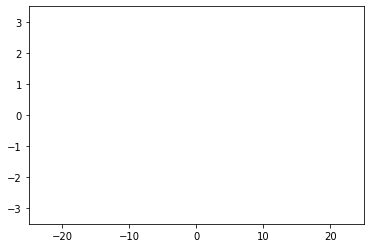

In [15]:
x = np.linspace(-10, 10, 10000)
y = np.sin(x)/x - x/10

x_y = list(zip(x, y))

dots = sample(x_y, 125)

x_ = [val[0] for val in dots]
y_ = [val[1] for val in dots]

pic_index = 0

plt.xlim(-25, 25)
plt.ylim(-3.5, 3.5)

def save_gen_obj_record(objs, save: bool, postfix=''):
    global pic_index
    
    obj = objs.detach().numpy()[0]
    x = [val[0] for val in obj]
    y = [val[1] for val in obj]
    plt.xlim(-10, 10)
    plt.ylim(-1.5, 1.5)
    
    plt.scatter(x_, y_)
    plt.scatter(x, y)
    
    if save:
        plt.savefig(os.path.join('pics_records', f'pic_{pic_index}_{postfix}.png'))
        pic_index += 1
        
        
def save_gen_obj(objs, save: bool, postfix=''):
    global pic_index
    
    obj = objs.detach().numpy()[0]
    x = [val[0] for val in obj]
    y = [val[1] for val in obj]
    plt.xlim(-10, 10)
    plt.ylim(-1.5, 1.5)
    
    plt.scatter(x_, y_)
    plt.scatter(x, y)
    
    if save:
        plt.savefig(os.path.join('pics', f'pic_{pic_index}_{postfix}.png'))
#         pic_index += 1

[Epoch 44/500] [Batch 1466/6250] [D loss: 0.294440] [G loss: 1.605664]


KeyboardInterrupt: 

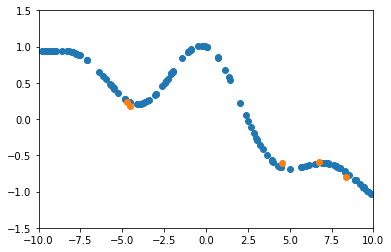

In [16]:
%matplotlib inline

d_losses = []
g_losses = []

lowest_gen_loss = np.inf

for epoch in range(n_epochs):
    for i, objs in enumerate(real_data_loader):

        batch_size = objs.shape[0]
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_objs = Variable(objs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_objs = generator(z)

        validity = discriminator(gen_objs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_objs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_objs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            if g_loss.item() < lowest_gen_loss:
                save_pic = True
                lowest_gen_loss = g_loss.item()
            else:
                save_pic = False
            save_gen_obj_record(objs=gen_objs, save=save_pic)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data)/batch_size, d_loss.item(), g_loss.item()) ) 
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            
            display.display(plt.gcf())

#             d_loss_history.append(d_loss)
#             g_loss_history.append(g_loss)

#             plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
#             plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
#             plt.legend(handles=[red_patch, green_patch])
#             plt.show()
    if epoch % 1 == 0:
        save_gen_obj(objs=gen_objs, save=True, postfix=f'epoch_{epoch}_{round(g_loss.item(), 3)}')

            

### Комментарии:

Как делал: нарезал точки с заданной кривой на серии - сначала генерил много много точек, принадлежащих заданной кривой, затем из них семплил серии, делал несколько эксперименов - серии по 25, 250, 5 точек. Нормально в результате обучения точки сгенеренной серии ложились на кривую при 5 точках, при 25 и 250 - не получалось - возможно там нужно кол-во эпох и объем данных на порядки больше. GIF для 5 и 250 прикладываю. Вернее на 250 и 25 точечных сериях вокруг двух экстремумов функции точки начани как-то кучковаться, т.е. видно, что обучение идет, но до повторения кривизны дело не дошло.

In [4]:
from IPython.display import Image
Image(url='5_points.gif') 

In [5]:
Image(url='250_points.gif') 

In [17]:
torch.save(generator.state_dict(), "gen.pth")
torch.save(discriminator.state_dict(), "disc.pth")